# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [189]:
# Load pickled data
import pickle

# Done: fill this in based on where you saved the training and testing data
training_file = "dataset/train.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Pickle files loaded succesfully")

Pickle files loaded succesfully


In [176]:
### To start off let's do a basic data summary.

# Done: number of training examples
n_train = len(X_train)

# Done: number of testing examples
n_test = len(X_test)

# Done: what's the shape of an image?
image_shape = train['sizes'][0]

# Done: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [30 29]
Number of classes = 43


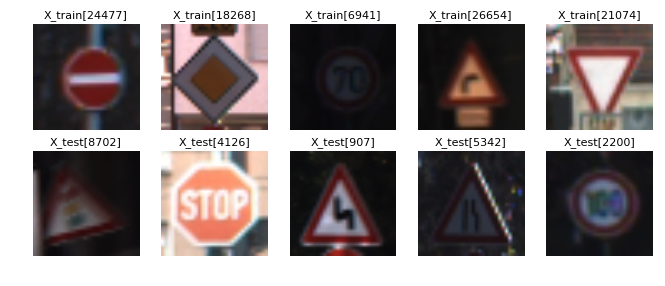

In [177]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
fig, axarr = plt.subplots(2,5, figsize=(8, 3))
for i in range(5):
    r1 = random.randint(0, len(X_train))
    r2 = random.randint(0, len(X_test))
    img_tr = X_train[r1]
    img_ts = X_test[r2]
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("X_train[%d]" % r1, fontsize=8)
    axarr[1, i].imshow(img_ts)
    axarr[1, i].axis("off")
    axarr[1, i].set_title("X_test[%d]" % r2, fontsize=8)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

# README: Proposal

I'll be trying to implement [Ciresan _et al._'s 2012 algorithm](http://people.idsia.ch/~juergen/nn2012traffic.pdf). They implemented a multi-column DNN, or "DNN committee", to achieve the [top performance in the GTSRB competition](http://benchmark.ini.rub.de/?section=gtsrb&subsection=results), with 99.46% precision. Figure 1 of the linked paper describes the approach, which in a very simplified manner is:

1. Each input is preprocessed by different methods;
2. Each preprocessed input is fed to a number of DNNs;
3. Output of all DNNs is averaged for each image.

Ciresan'12 reports that each individual DNN in the ensemble achieved precision above 98%. My personal target for this submission is 95% precision, although I'd be happy with 90% and willing to accept anything above 80% at this stage, due to time constraints related to the course timeline. Due to my humbler aspirations, a number of simplifications will be made on the original algorithm:

1. A single DNN will be used instead of an ensemble, to avoid the computational cost associated with training multiple neural nets on thousands of images;
2. Because of the above, a single preprocessing method will be used instead of three;
3. During training, the distortion step will be dropped.

These changes are documented and explained more thoroughly in the corresponding sections.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [178]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2

def preprocess(image):
    # 1. Resample image
    new_size = (56, 56)
    img_rs = np.zeros(new_size)
    # a. If image size is new_size, do nothing:
    if image.shape == new_size:
        img_rs = image
    # b. If image is larger, shrink using recommended downsizing interpolation
    elif image.shape > new_size:
        img_rs = cv2.resize(src = image, dsize = new_size, interpolation = INTER_AREA)
    # c. If image is smaller, zoom using bilinear interpolation, which is the default
    else: 
        img_rs = cv2.resize(src = image, dsize = new_size)
    
    # 2. Crop a 10% border of the image, as per Ciresan'12
    sz = new_size[0] - 48
    img_48 = img_rs[sz:-sz,sz:-sz]
    
    # 3. Normalise image as per sermanet'11
    # a. Convert image to YUV space
    yuv = cv2.cvtColor(img_48, cv2.COLOR_BGR2YUV)
    # b. Normalise Y channel using adaptive histogram equalization, chosen from Ciresan'12
    clahe = cv2.createCLAHE(clipLimit = 1, tileGridSize=(6,6))
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    norm = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    return norm

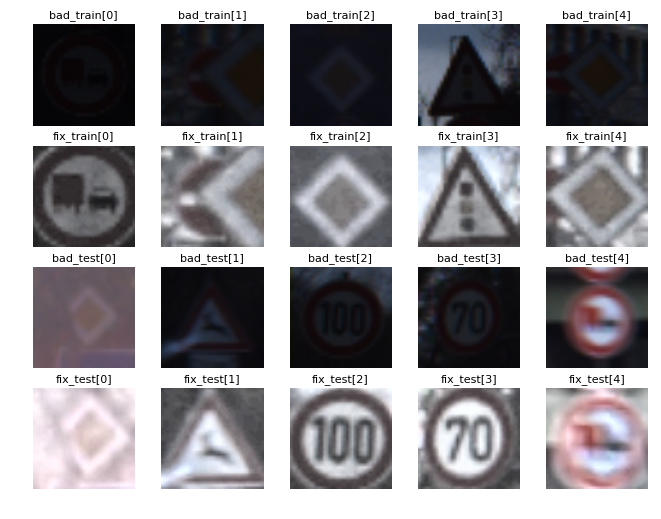

In [179]:
# Test 1: particularly bad images chosen at random by visual inspection
bad_train = [X_train[16287], X_train[24649], X_train[18641], X_train[30115], X_train[19010]]
bad_test = [X_test[1618], X_test[1339], X_test[9265], X_test[11413],X_test[3301]]

fig, axarr = plt.subplots(4,5, figsize=(8, 6))
for i in range(5):
    img_tr = bad_train[i]
    fix_tr = preprocess(img_tr)
    img_ts = bad_test[i]
    fix_ts = preprocess(img_ts)
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("bad_train[%d]" % i, fontsize=8)
    axarr[1, i].imshow(fix_tr, cmap="Greys_r")
    axarr[1, i].axis("off")
    axarr[1, i].set_title("fix_train[%d]" % i, fontsize=8)
    axarr[2, i].imshow(img_ts)
    axarr[2, i].axis("off")
    axarr[2, i].set_title("bad_test[%d]" % i, fontsize=8)
    axarr[3, i].imshow(fix_ts, cmap="Greys_r")
    axarr[3, i].axis("off")
    axarr[3, i].set_title("fix_test[%d]" % i, fontsize=8)

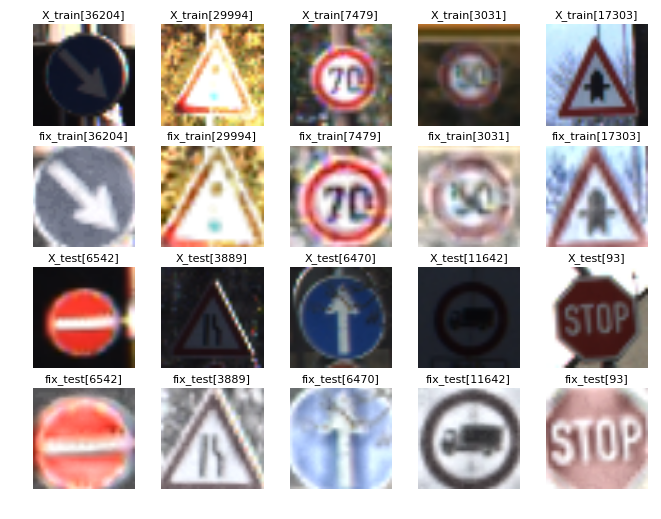

In [181]:
# Test 2: random images

fig, axarr = plt.subplots(4,5, figsize=(8, 6))
for i in range(5):
    r1 = random.randint(0, len(X_train))
    r2 = random.randint(0, len(X_test))
    img_tr = X_train[r1]
    fix_tr = preprocess(img_tr)
    img_ts = X_test[r2]
    fix_ts = preprocess(img_ts)
    axarr[0, i].imshow(img_tr)
    axarr[0, i].axis("off")
    axarr[0, i].set_title("X_train[%d]" % r1, fontsize=8)
    axarr[1, i].imshow(fix_tr, cmap="Greys_r")
    axarr[1, i].axis("off")
    axarr[1, i].set_title("fix_train[%d]" % r1, fontsize=8)
    axarr[2, i].imshow(img_ts)
    axarr[2, i].axis("off")
    axarr[2, i].set_title("X_test[%d]" % r2, fontsize=8)
    axarr[3, i].imshow(fix_ts, cmap="Greys_r")
    axarr[3, i].axis("off")
    axarr[3, i].set_title("fix_test[%d]" % r2, fontsize=8)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Steps within the `preprocess` function:
1. resample image to 56x56
2. crop 6 pixels from the borders to yield a 48 x 48 image
3. Normalise using Contrast Limited Adaptive Histogram Equalisation, or [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization), on the Y channel of YUV image to improve contrast. Parameters: clip limit of 1, 6x6 grid.

I'm not sure if the adaptive histogram equalisation used in Ciresan'12 was contrast limited. However, results obtained are similar to the ones reported. I'm also not sure if the border trimming reported in Ciresan'12 was performed computationally, it'd be possible to attempt this method without the cropping step. The cropped amount (8 pixels) was chosen after a few attempts, by visual inspection of small samples.

The preprocessing step seemingly discarded mostly useless information, and greatly improve the visibility of very dark images, even allowing for color recognition (see test 1, case `bad_train[3]`). Quality of images with better visibility isn't terribly affected, although blue signs with decent visibility seem to suffer a bit (see test 2). 

In [191]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

At this stage, the need to generate additional data hasn't prevented itself, but this step might be revisited after getting initial results.

In [188]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

#


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Same architecture will be used here as in Ciresan'12. These are the layers used:

0. Input - 48×48×3 (RGB image)
1. Convolution - 42×42×100 (7×7 kernel)
2. Max-pooling - 21×21×100 (2×2 kernel)
3. Convolution - 18×18×150 (4×4 kernel)
4. Max-pooling - 9×9×150 (2×2 kernel)
5. Convolution - 6×6×250 (4×4 kernel)
6. Max-pooling - 3×3×250 (2×2 kernel)
7. Fully connected - 300
8. Output - 43

Training time reported in the papers was 37h for an ensemble of 25 DNNS, using a machine with 3.3GHz, 24GB DDR3 and four GTX580 GPUs. The machine available to me has 2.7GHz, 16GB DDR3 and one GT650 GPU. It's hard to estimate, but I'm hoping a single DNN with this configuration will be successfully trained overnight.

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I researched the literature on this exact problem, compared a few approaches and chose this one because:

1. It had top performance in the competition;
2. It seemed well-documented enough that reproducing the results should be straightforward;
3. The algorithm described showed several opportunities for simplification.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.